In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image
import torch
import gc
import os
import time
#Pour identifier les fichier parquet dont nous avons besoin:
for dirname,_,filenames in os.walk('data\Alzheimer MRI Disease Classification Dataset\Data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

data\Alzheimer MRI Disease Classification Dataset\Data\test-00000-of-00001-44110b9df98c5585.parquet
data\Alzheimer MRI Disease Classification Dataset\Data\train-00000-of-00001-c08a401c53fe5312.parquet


In [64]:
def load_data(base_dir):
    df_train = pd.read_parquet(f"{base_dir}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
    df_test = pd.read_parquet(f"{base_dir}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
    return df_train, df_test
directory="data\Alzheimer MRI Disease Classification Dataset\Data"
df_train, df_test = load_data(directory)


In [65]:
def dict_to_image(image_dict):
    byte_string=image_dict['bytes']
    nparr=np.frombuffer(byte_string,np.uint8)
    img=cv2.imdecode(nparr,cv2.IMREAD_GRAYSCALE)
    return img
def preprocess_data(df):
    df['image_arr']=df["image"].apply(dict_to_image)
    df.drop('image',axis=1,inplace=True)
    return df
df_train=preprocess_data(df_train)
df_test=preprocess_data(df_test)


In [66]:
print(df_train.columns, df_train.shape) #Bien une image noir et blanc avec le label

Index(['label', 'image_arr'], dtype='object') (5120, 2)


In [97]:
N_CLASSES= df_train['label'].nunique()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


0.0
1729900766.4235997
1729900766.4235997


In [68]:
class ImageDataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe=dataframe.reset_index(drop=True)
        self.transform=transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        image=self.dataframe.iloc[idx]['image_arr']
        label=self.dataframe.iloc[idx]['label']
        image=Image.fromarray(image.astype(np.uint8))
        if self.transform:
            image=self.transform(image)
        else:
            image=transforms.ToTensor()(image)
        label=torch.tensor(label,dtype=torch.long)
        return image,label
    

In [69]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])


In [70]:

batch_size = 64
train_dataset = ImageDataset(df_train, transform=transforms_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = ImageDataset(df_test, transform=transforms_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [81]:

class ModelA(nn.Module):
    def __init__(self):
        super(ModelA,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.drop1 = nn.Dropout(p=0.2)
        self.out = nn.Linear(128, N_CLASSES)
        
    def forward(self, x):
        x = F.mish(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.mish(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.drop1(x)
        x = self.out(x)
        return x

    


In [125]:
class ModelB(nn.Module):
    def __init__(self):
        super(ModelB, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 4 * 4, 128)
        self.drop1 = nn.Dropout(p=0.2)
        self.out = nn.Linear(128, N_CLASSES)

    def forward(self, x):
        x = F.mish(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        
        x = F.mish(self.conv2(x))
        x = self.pool2(x)
        
        x = F.mish(self.conv3(x))
        x = self.pool3(x)
        
        x = F.mish(self.conv4(x))
        x = self.pool4(x)
        
        x = F.mish(self.conv5(x))
        x = self.pool5(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.drop1(x)
        x = self.out(x)
        return x


class ModelC(nn.Module):
    def __init__(self):
        super(ModelC, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.batchnorm4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024 * 4 * 4, 256)  
        self.drop1 = nn.Dropout(p=0.3)
        self.out = nn.Linear(256, N_CLASSES)

    def forward(self, x):
        x = F.mish(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        
        x = F.mish(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        
        x = F.mish(self.conv3(x))
        x = self.pool3(x)
        x = self.batchnorm3(x)
        
        x = F.mish(self.conv4(x))
        x = self.pool4(x)
        x = self.batchnorm4(x)
        
        x = F.mish(self.conv5(x))
        x = self.pool5(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.drop1(x)
        x = self.out(x)
        return x

    
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.batchnorm4 = nn.BatchNorm2d(1024)
        
        self.conv5 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.batchnorm5 = nn.BatchNorm2d(2048)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048 * 4 * 4, 512) 
        self.drop1 = nn.Dropout(p=0.4)
        self.out = nn.Linear(512, N_CLASSES)

    def forward(self, x):
        x = F.mish(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        
        x = F.mish(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        
        x = F.mish(self.conv3(x))
        x = self.pool3(x)
        x = self.batchnorm3(x)
        
        x = F.mish(self.conv4(x))
        x = self.pool4(x)
        x = self.batchnorm4(x)
        
        x = F.mish(self.conv5(x))
        x = self.pool5(x)
        x = self.batchnorm5(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.drop1(x)
        x = self.out(x)
        return x

class ModelF(nn.Module):
    def __init__(self):
        super(ModelF, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.batchnorm4 = nn.BatchNorm2d(1024)
        
        self.conv5 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.batchnorm5 = nn.BatchNorm2d(2048)
        
        self.conv6 = nn.Conv2d(2048, 4096, kernel_size=3, padding=1)  
        self.pool6 = nn.MaxPool2d(2, 2)
        self.batchnorm6 = nn.BatchNorm2d(4096)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4096 * 2 * 2, 1024) 
        self.drop1 = nn.Dropout(p=0.5)
        self.out = nn.Linear(1024, N_CLASSES)

    def forward(self, x):
        x = F.mish(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        
        x = F.mish(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        
        x = F.mish(self.conv3(x))
        x = self.pool3(x)
        x = self.batchnorm3(x)
        
        x = F.mish(self.conv4(x))
        x = self.pool4(x)
        x = self.batchnorm4(x)
        
        x = F.mish(self.conv5(x))
        x = self.pool5(x)
        x = self.batchnorm5(x)
        
        x = F.mish(self.conv6(x))
        x = self.pool6(x)
        x = self.batchnorm6(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.drop1(x)
        x = self.out(x)
        
        return x


In [108]:
def train_model(model,train_loader,test_loader,optimizer,criterion,device,num_epochs,patience=50):
    model.to(device)
    train_losses=[]
    test_losses=[]
    train_accuracies=[]
    test_accuracies=[]
    best_loss=float('inf')
    epochs_w_imp=0
    best_model_state=None
    for epoch in tqdm.tqdm(range(num_epochs),total=num_epochs):
        model.train()
        running_loss=0.0 # float pour eviter les erreurs
        correct=0
        total=0
        for inputs,labels in train_loader:
            inputs,labels=inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            _,preds=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(preds==labels).sum().item()
        train_loss= running_loss/len(train_loader)
        train_acc=correct/total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        model.eval()
        val_loss=0.0
        correct=0
        total=0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs,labels=inputs.to(device),labels.to(device)
                outputs=model(inputs)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _,preds=torch.max(outputs,1)
                total+= labels.size(0)
                correct+=(preds==labels).sum().item()
            val_loss /= len(test_loader)
            val_acc=correct/total
            test_losses.append(val_loss)
            test_accuracies.append(val_acc)
            if val_loss<best_loss:
                best_loss=val_loss
                epochs_w_imp=0
                best_model_state=model.state_dict()
            else:
                epochs_w_imp+=1
                if epochs_w_imp==patience:
                    print(f'Early stop {epoch+1}')
                    model.load_state_dict(best_model_state)
                    break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, test_losses, train_accuracies, test_accuracies



In [109]:
num_epochs = 450
patience = 50
results = []
device
criterion = nn.CrossEntropyLoss()
model_list = [
    ('Petit modèle', ModelA()),
]
torch.cuda.empty_cache()
gc.collect()


1440

In [110]:

for model_name, model in model_list:
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, test_loader, optimizer, criterion, device, num_epochs, patience=patience)
    results.append({
        'model_name': model_name,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'model': model
    })
    torch.cuda.empty_cache()
    gc.collect()



 87%|████████▋ | 390/450 [7:02:47<1:05:02, 65.04s/it]

Early stop 391


Model: Petit modèle
Final Train Accuracy: 0.9207
Final Test Accuracy: 0.9602



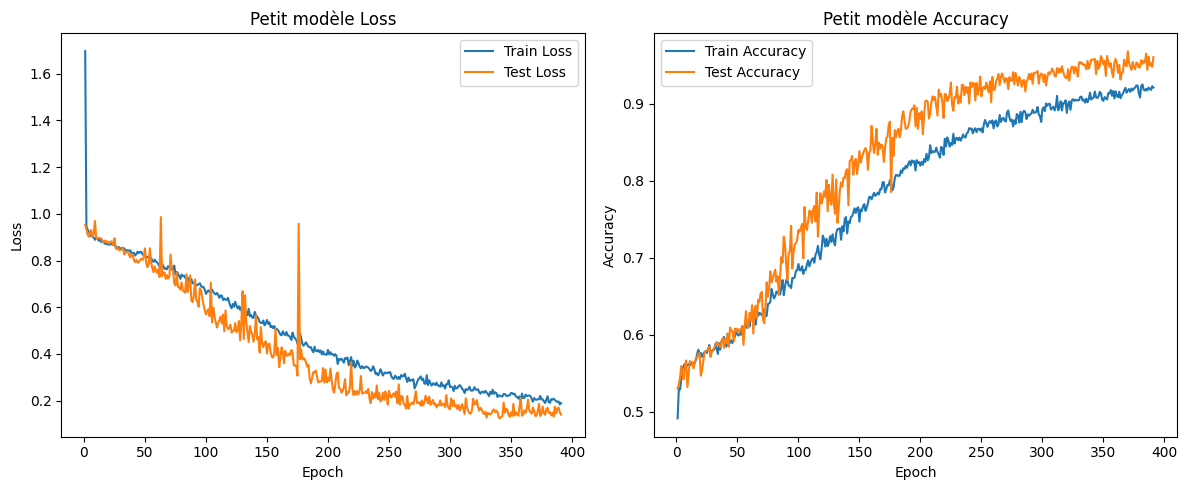

In [111]:
for res in results:
    model_name = res['model_name']
    train_acc = res['train_accuracies'][-1]
    val_acc = res['val_accuracies'][-1]
    print(f"Model: {model_name}")
    print(f"Final Train Accuracy: {train_acc:.4f}")
    print(f"Final Test Accuracy: {val_acc:.4f}")
    print()


for res in results:
    model_name = res['model_name']
    train_losses = res['train_losses']
    val_losses = res['val_losses']
    train_accuracies = res['train_accuracies']
    val_accuracies = res['val_accuracies']
    epochs = range(1, len(train_losses)+1)
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Test Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In [113]:
modelAfinal=model

In [120]:
torch.save(modelAfinal.state_dict(),'modelA')

In [123]:
model.load_state_dict(torch.load('ModelA'))
model.eval()

ModelA(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=128, out_features=4, bias=True)
)

In [132]:
num_epochs = 450
patience = 50
results = []
device
criterion = nn.CrossEntropyLoss()
model_list = [
    ('Moins petit modèle', ModelB()),
]
torch.cuda.empty_cache()
gc.collect()


7507

In [129]:

for model_name, model in model_list:
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, test_loader, optimizer, criterion, device, num_epochs, patience=patience)
    results.append({
        'model_name': model_name,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'model': model
    })
    torch.cuda.empty_cache()
    gc.collect()



 80%|████████  | 360/450 [8:46:16<2:11:34, 87.71s/it]

Early stop 361


Model: Moins petit modèle
Final Train Accuracy: 0.9387
Final Test Accuracy: 0.9375



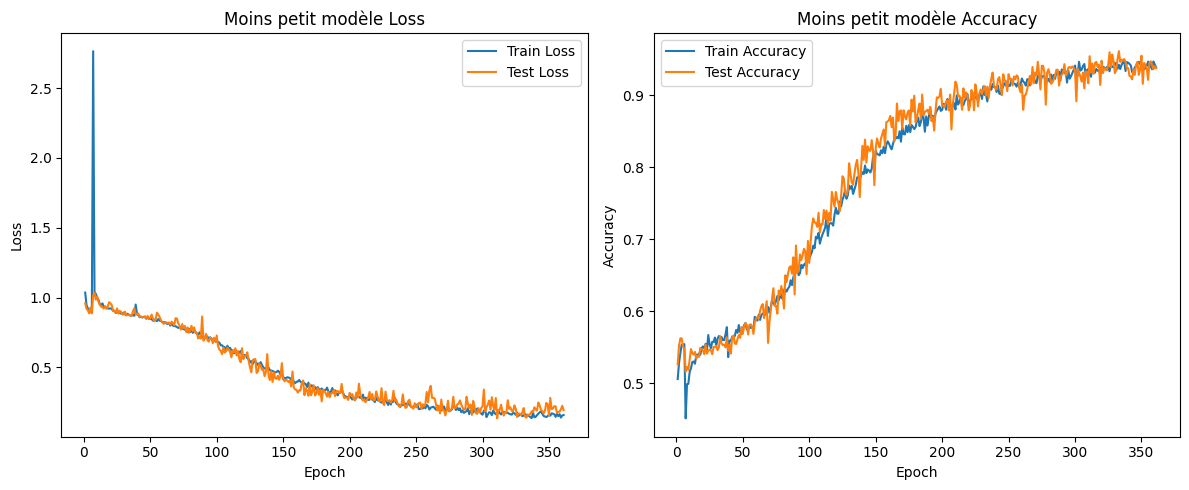

In [130]:
for res in results:
    model_name = res['model_name']
    train_acc = res['train_accuracies'][-1]
    val_acc = res['val_accuracies'][-1]
    print(f"Model: {model_name}")
    print(f"Final Train Accuracy: {train_acc:.4f}")
    print(f"Final Test Accuracy: {val_acc:.4f}")
    print()


for res in results:
    model_name = res['model_name']
    train_losses = res['train_losses']
    val_losses = res['val_losses']
    train_accuracies = res['train_accuracies']
    val_accuracies = res['val_accuracies']
    epochs = range(1, len(train_losses)+1)
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Test Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In [131]:
modelBfinal=model

torch.save(modelBfinal.state_dict(),'modelB')

In [133]:
num_epochs = 450
patience = 50
results = []

criterion = nn.CrossEntropyLoss()
model_list = [
    ('Mid model', ModelB()),
]
torch.cuda.empty_cache()
gc.collect()


0

In [134]:

for model_name, model in model_list:
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, test_loader, optimizer, criterion, device, num_epochs, patience=patience)
    results.append({
        'model_name': model_name,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'model': model
    })
    torch.cuda.empty_cache()
    gc.collect()


 42%|████▏     | 187/450 [4:46:50<6:43:25, 92.04s/it]

Early stop 188


In [135]:
modelBfinal=model

torch.save(modelBfinal.state_dict(),'modelB')

Model: Mid model
Final Train Accuracy: 0.9590
Final Test Accuracy: 0.9609



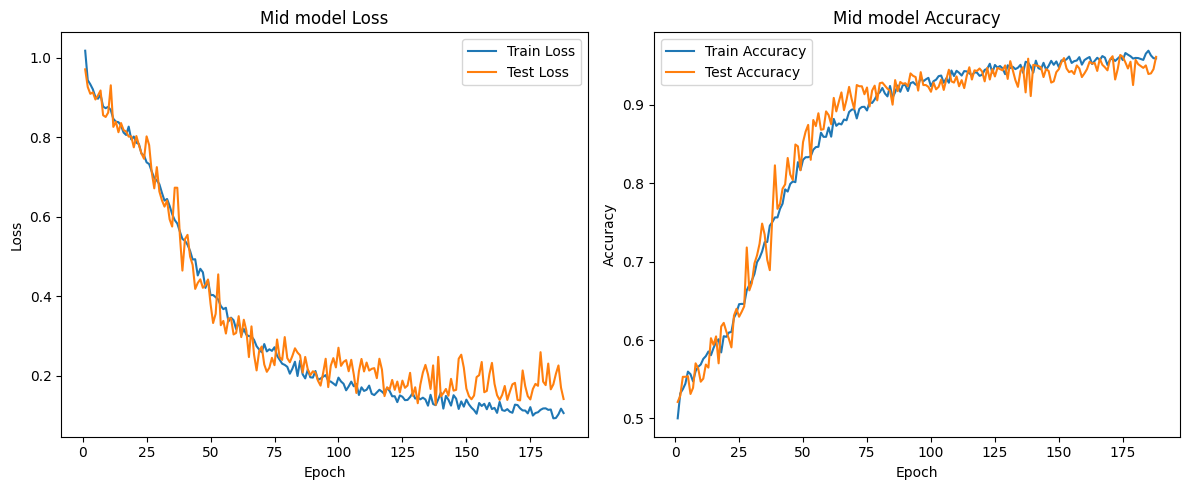

In [136]:
for res in results:
    model_name = res['model_name']
    train_acc = res['train_accuracies'][-1]
    val_acc = res['val_accuracies'][-1]
    print(f"Model: {model_name}")
    print(f"Final Train Accuracy: {train_acc:.4f}")
    print(f"Final Test Accuracy: {val_acc:.4f}")
    print()


for res in results:
    model_name = res['model_name']
    train_losses = res['train_losses']
    val_losses = res['val_losses']
    train_accuracies = res['train_accuracies']
    val_accuracies = res['val_accuracies']
    epochs = range(1, len(train_losses)+1)
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Test Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In [137]:
num_epochs = 450
patience = 50
results = []

criterion = nn.CrossEntropyLoss()
model_list = [
    ('vrai Mid model', ModelC()),
]
torch.cuda.empty_cache()
gc.collect()


7485

In [141]:

for model_name, model in model_list:
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, test_loader, optimizer, criterion, device, num_epochs, patience=patience)
    results.append({
        'model_name': model_name,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'model': model
    })
    torch.cuda.empty_cache()
    gc.collect()


 42%|████▏     | 191/450 [11:26:30<15:30:55, 215.66s/it]

Early stop 192


In [142]:
modelCfinal=model

torch.save(modelCfinal.state_dict(),'modelC')

Model: vrai Mid model
Final Train Accuracy: 0.9611
Final Test Accuracy: 0.9594



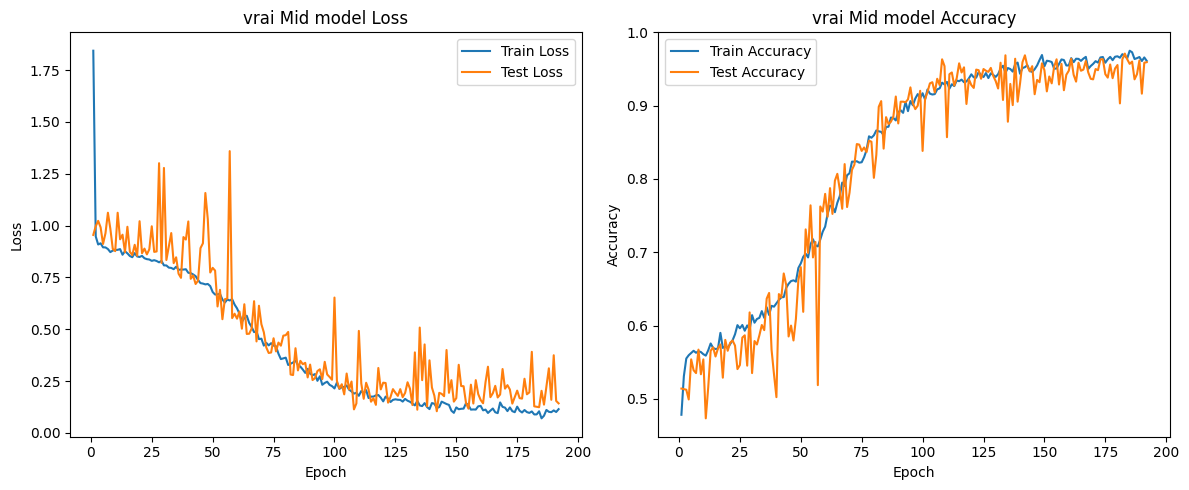

In [143]:
for res in results:
    model_name = res['model_name']
    train_acc = res['train_accuracies'][-1]
    val_acc = res['val_accuracies'][-1]
    print(f"Model: {model_name}")
    print(f"Final Train Accuracy: {train_acc:.4f}")
    print(f"Final Test Accuracy: {val_acc:.4f}")
    print()


for res in results:
    model_name = res['model_name']
    train_losses = res['train_losses']
    val_losses = res['val_losses']
    train_accuracies = res['train_accuracies']
    val_accuracies = res['val_accuracies']
    epochs = range(1, len(train_losses)+1)
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Test Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

